# Titanic Survial 
Using models like xgboost, kNN and descision tree to find the survial if you where on titanic.

In [1]:
import pandas as pd
gender=pd.read_csv('./titanic/gender_submission.csv')
test=pd.read_csv('./titanic/test.csv')
train=pd.read_csv('./titanic/train.csv')

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000


Cabin will now be dropped as it is to hard to fill and is not the most useful. As embarked is the how purpose of this project the 2 missing values will also be droped. Age however will be looking into replacing as it will probably be very useful. 

In [4]:
train.drop(["Cabin","Ticket"], axis = 1, inplace = True)
test.drop(["Cabin","Ticket"], axis = 1, inplace = True)
train.drop(train.loc[train['Embarked'].isnull()].index, inplace = True)
train.drop(train.loc[train['Age'].isnull()].index, inplace = True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Fare         712 non-null    float64
 9   Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 61.2+ KB


## Data Exploration

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [7]:
train.describe(include=['O'])

,Name,Sex,Embarked
count,712,712,712
unique,712,2,3
top,"Braund, Mr. Owen Harris",male,S
freq,1,453,554


# Data Clearning and Feature Engineering

In [8]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train.drop(["Name"], axis = 1, inplace = True)
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,5
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,36


In [9]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

In [10]:
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test.drop(["Name"], axis = 1, inplace = True)
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

This has now dealt with the name column and turns into something we are more likely to be able to use.

## Note 
I will look at imputting the ages and make more features at a future point, for now I will move onto actually training the models. 

In [11]:
train.head()
test.drop(["PassengerId"], axis = 1, inplace = True)
train.drop(["PassengerId"], axis = 1, inplace = True)

## Machine Learning
Now we can move onto the actual machine learning, first however we will need to make a test train split and a evaluation function. Then the following models will be trained.
* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest

The first thing that needs to be done though is make a test train split for the data set. The data then needs to be transformed by scaling the features, and encoding the catagorical varibles.

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

train_set, test_set = train_test_split(train,test_size=0.2)
train_y=train_set["Survived"]
train_x=train_set.drop(["Survived"], axis=1)
test_y=test_set["Survived"]
test_x=test_set.drop(["Survived"], axis=1)
train_set_num=train_x.select_dtypes(include=[np.number])
train_set_ob=train_x.select_dtypes(include=[object])
num_column=list(train_set_num.columns)
ob_column=list(train_set_ob.columns)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_column),
        ("cat", OrdinalEncoder(), ob_column),
    ])

train_x = full_pipeline.fit_transform(train_x)
test_x = full_pipeline.fit_transform(test_x)

#### Metrics and Graphs
The metrics that are used to measure the quality of a classifer are:
* **Model score (score):** This method computes the accuracy score (accuracy is #correct_preds / #all_preds)
* **Cross val score:** As some classifeirs have the tendecy to overfit it is sometimes useful to do a cross val score. This is when the training set in divided up into different folds and it goes through each fold as a test set while the rest the model is train on.
* **f1 score:** The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. This is only for binary classifiers though.
* **Confustion Matrix:** This is a very easy way to identify the number of misslabeled events. Simply it counts the number of class A's indentified as class A and class B.
* **Precision Recall:** The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).
* **ROC curve:** This is very similar to the precision recall graph however it plots true possitve rate (recall) against false positive rate. This is the ratio of negative instances that are incorrectly classified as posotive and is equal to 1-true negative rate.

In [38]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay


def eval(model):
    ymul=model.predict(test_x)
    print("Model score: %.4f" % model.score(test_x,test_y))  
    print("The cross val score with 3 folds: ", cross_val_score(model, train_x, train_y, cv=3, scoring="accuracy"))
    print("F1-score: %.4f" % f1_score(test_y , ymul) )
    
    dis = ConfusionMatrixDisplay.from_estimator(model,test_x, test_y)
    fig, ax = plt.subplots(figsize=(6, 6))
    PrecisionRecallDisplay.from_estimator(model, test_x, test_y,ax=ax)
    ax.set_title("2-class Precision-Recall curve")
    dis1 = RocCurveDisplay.from_estimator(model, test_x, test_y)

### Desesion Trees and Random Forest
A decision tree is normally used for classification but can also but done for regression. A decision tree works by asking a intial question at the root node for instance in this case is the sale condition normal and then depending on the answer you go down one of the nodes to another question if needed (for simple datasets it may not be needed to be able to divide the data up). You measure the impurity of the node called gini, if the node is complety pure then it would =0. In skearn it uses the CART algorithm, this works by splitting the data set into 2 subsets using a single feature and a threshold, it then continues to do this until the max depth is reached or a split will not reduce the impurity.           
A random forest algorthim is a ensemble of decesion trees trained using the bagging method. This involves using the same algorithm and training them on a subets of the training data, once this is done the ensemble makes predictions by agregating the result (most frequent for classification and average for regression). This will normally purform better than a decision tree.             

Model score: 0.7343
The cross val score with 3 folds:  [0.76842105 0.79473684 0.75661376]
F1-score: 0.6935


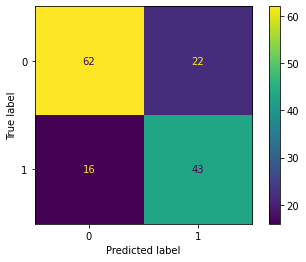

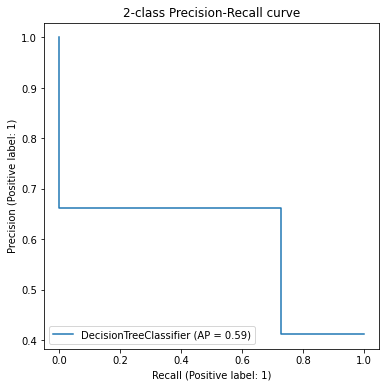

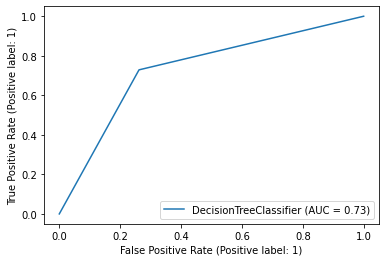

In [39]:
from sklearn.tree import DecisionTreeClassifier

tree_reg = DecisionTreeClassifier()
tree_reg.fit(train_x,train_y)
eval(tree_reg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(train_x,train_y)
eval(forest_clf)

### K Nearest Neighbors
K-Nearest Neighbors is a supervised learning algorithm. Where the data is 'trained' with data points corresponding to their classification. To predict the class of a given data point, it takes into account the classes of the 'K' nearest data points and chooses the class in which the majority of the 'K' nearest data points belong to as the predicted class.

Model score: 0.7203
The cross val score with 3 folds:  [0.83157895 0.82631579 0.75661376]
F1-score: 0.6364


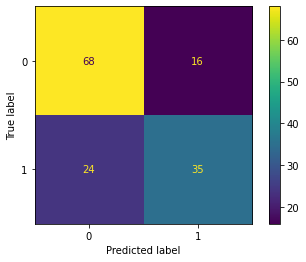

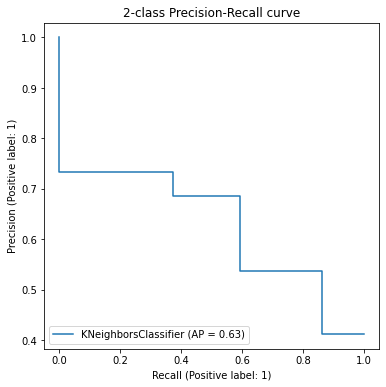

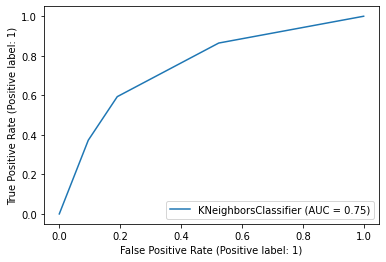

In [49]:
from sklearn.neighbors import KNeighborsClassifier

k=3

neigh = KNeighborsClassifier(n_neighbors = k)
neigh.fit(train_x,train_y)
eval(neigh)

This model is highly dependent on the value of k. This means that it is key to optimise this value. One way to do this is to loop over different values of k and plot the accuracy of the model against K, this will give you the best value for k.

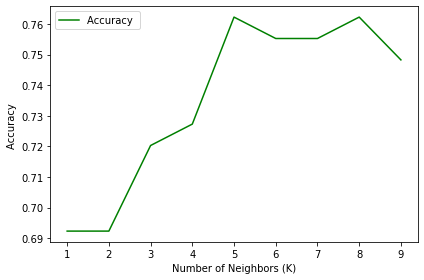

In [50]:
Ks = 10
mean_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_x,train_y)
    yhat=neigh.predict(test_x)
    mean_acc[n-1] = neigh.score(test_x,test_y)

plt.plot(range(1,Ks),mean_acc,'g')
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

This shows a high increase in the accuracu of the model when using k=5 instead of 3.

Model score: 0.7622
The cross val score with 3 folds:  [0.84210526 0.81052632 0.77777778]
F1-score: 0.6852


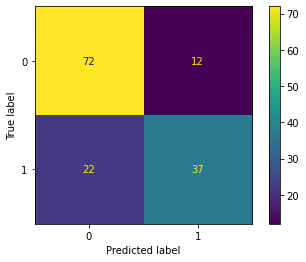

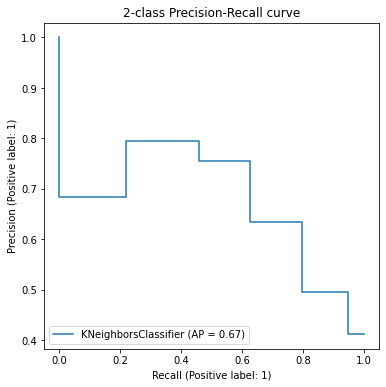

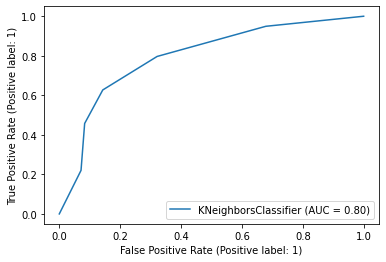

In [51]:
new_k=5
neigh2 = KNeighborsClassifier(n_neighbors = new_k)
neigh2.fit(train_x,train_y)
eval(neigh2)

### SVC

Model score: 0.7273
The cross val score with 3 folds:  [0.83684211 0.79473684 0.74603175]
F1-score: 0.6549


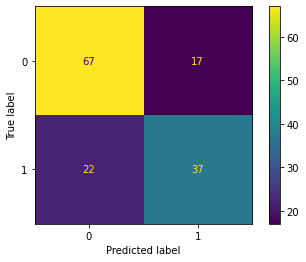

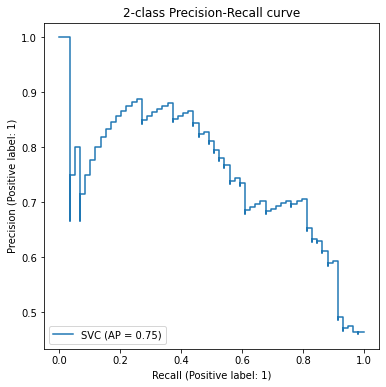

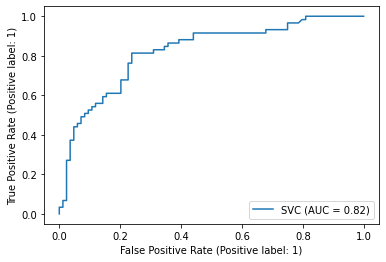

In [52]:
from sklearn.svm import SVC

svc_lin=SVC(kernel="linear", C=0.025)
svc_lin.fit(train_x,train_y)
eval(svc_lin)

Model score: 0.7063
The cross val score with 3 folds:  [0.85263158 0.81052632 0.75132275]
F1-score: 0.6441


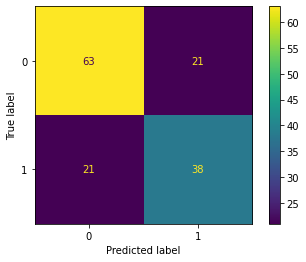

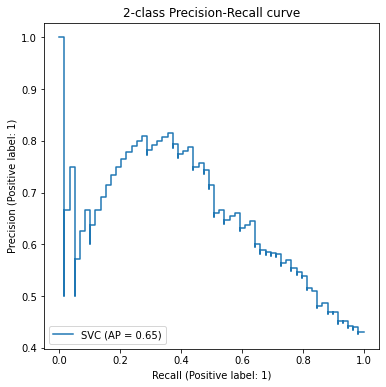

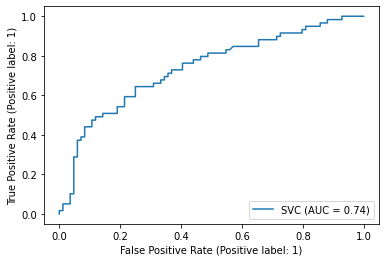

In [53]:
from sklearn.svm import SVC

svc_gamma=SVC(gamma=2, C=1)
svc_gamma.fit(train_x,train_y)
eval(svc_gamma)

### AdaBoost
Using adaboost is when the next training instance pays more atention to previous training instances where it underfitted. This will keep going focussing on the harder to fit cases. For example when the first algorithm trains it will have some misslassified training instances, on the next instance it will increase the weight of the missclassified instances and then trains again. This will produces the final model.

Model score: 0.7203
The cross val score with 3 folds:  [0.80526316 0.84210526 0.76719577]
F1-score: 0.6226


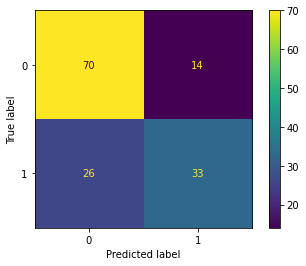

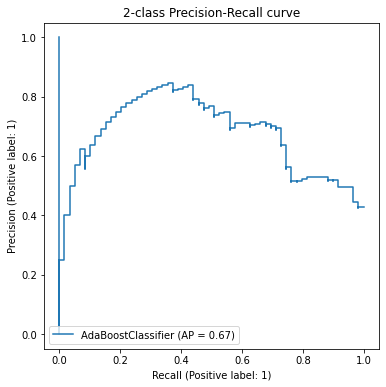

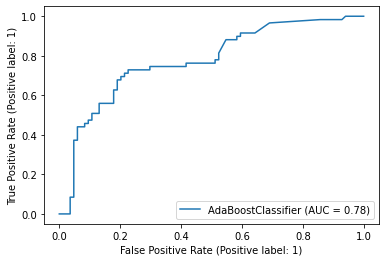

In [54]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(train_x,train_y)
eval(clf)